In [237]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

In [238]:
train_data = pd.read_csv('train_processed.csv')
test_data = pd.read_csv('test_processed.csv')

In [239]:
df = pd.concat([train_data, test_data])

In [240]:
date_cols = [col for col in df.columns if 'date' in col]
for col in date_cols:
    df[col] = pd.to_datetime(df[col])

In [241]:
lenders = pd.get_dummies(df['lender_id']).astype(int)
loan_types = pd.get_dummies(df['loan_type'], prefix='loan_type').astype(int)

In [242]:
cluster_map = {
        name: f'cluster_{chr(idx + ord("A"))}'  # chr(idx + ord('A')) converts 0 -> 'A', 1 -> 'B', etc.
        for idx, name in enumerate(df['cluster'].unique())
    }

df['cluster'] = df['cluster'].map(cluster_map)
clusters = pd.get_dummies(df['cluster']).astype(int)

In [243]:
df['target'].value_counts()

target
0.0    85990
1.0     1258
Name: count, dtype: int64

In [244]:
train_data['target'].value_counts()

target
0.0    67396
1.0     1258
Name: count, dtype: int64

In [245]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87248 entries, 0 to 18593
Data columns (total 41 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   id                           87248 non-null  object        
 1   customer_id                  87248 non-null  int64         
 2   country_id                   87248 non-null  object        
 3   tbl_loan_id                  87248 non-null  int64         
 4   lender_id                    87248 non-null  object        
 5   loan_type                    87248 non-null  object        
 6   monetary                     87248 non-null  float64       
 7   total_amount_to_repay        87248 non-null  float64       
 8   disbursement_date            87248 non-null  datetime64[ns]
 9   due_date                     87248 non-null  datetime64[ns]
 10  duration                     87248 non-null  int64         
 11  new                          87248 non-null  i

In [246]:
df = pd.concat([df,lenders,loan_types,clusters], axis=1)

In [247]:
econ_df = pd.read_csv('african-credit-scoring-challenge20241129-14702-1nqro8v/economic_indicators.csv')
col_map = {year:year.strip('YR') for year in econ_df.columns}
econ_df = econ_df[econ_df['Country'] != "Cote d'Ivoire"]
econ_df.rename(columns = col_map, inplace= True)
econ_df = econ_df.melt(id_vars=['Country', 'Indicator'], 
                      var_name='year', 
                      value_name='value')
econ_df['year'] = econ_df['year'].astype(int)
econ_df

,Country,Indicator,year,value
0,Ghana,"Inflation, consumer prices (annual %)",2001,41.509496
1,Kenya,"Inflation, consumer prices (annual %)",2001,5.738598
2,Ghana,"Official exchange rate (LCU per US$, period av...",2001,0.716305
3,Kenya,"Official exchange rate (LCU per US$, period av...",2001,78.563195
4,Ghana,Real interest rate (%),2001,NaN
...,...,...,...,...
409,Kenya,Interest rate spread (lending rate minus depos...,2023,4.420812
410,Ghana,Fossil fuel energy consumption (% of total),2023,NaN
411,Kenya,Fossil fuel energy consumption (% of total),2023,NaN
412,Ghana,Unemployment rate,2023,3.079000


<Axes: >

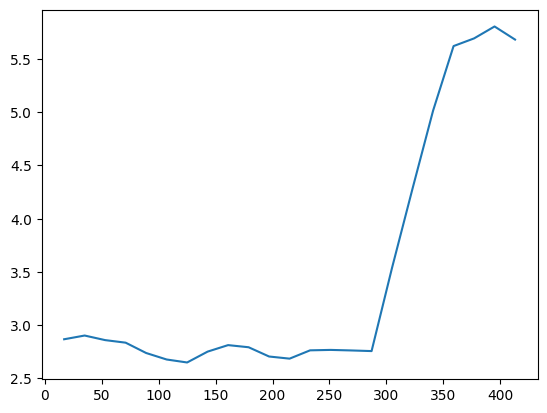

In [248]:
kenya_inf_df = econ_df[(econ_df['Country']=='Kenya') & (econ_df['Indicator']=='Unemployment rate')]
kenya_inf_df['value'].plot()

In [249]:
econ_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414 entries, 0 to 413
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Country    414 non-null    object 
 1   Indicator  414 non-null    object 
 2   year       414 non-null    int32  
 3   value      323 non-null    float64
dtypes: float64(1), int32(1), object(2)
memory usage: 11.4+ KB


In [250]:
def prepare_economic_data(econ_df):
    """
    Pivot the economic data with handling for duplicate values.
    """
    INDICATOR_MAP = {
        'Inflation, consumer prices (annual %)': 'inflation',
        'Official exchange rate (LCU per US$, period average)': 'exchange_rate',
        'Deposit interest rate (%)': 'deposit_rate',
        'Unemployment rate': 'unemployment_rate'
    }
    
    filtered_df = econ_df[
        econ_df['Indicator'].isin(INDICATOR_MAP.keys())
    ].copy()
    
    # Pivot with handling for duplicates
    pivot_df = (filtered_df
        .pivot_table(
            index=['Country', 'year'],
            columns='Indicator',
            values='value',
            aggfunc='first'  # Takes first value if duplicates exist
        )
        .rename(columns=INDICATOR_MAP)
        .reset_index()
    )
    
    # Sort and forward fill without using groupby
    pivot_df = (pivot_df
        .sort_values(['Country', 'year'])
        .fillna(method='ffill')
    )
    
    return pivot_df

def add_economic_indicators(df, econ_df):
    """
    Add economic indicators with optimized merging and data handling.
    """
    # Sort first
    df_sorted = df.sort_values('disbursement_date')
    
    # Store targets after sorting
    targets = df_sorted['target'].copy()
    df_sorted = df_sorted.drop(columns='target')
    
    # Prepare and merge data
    economic_data = prepare_economic_data(econ_df)
    merged_df = pd.merge(
        df_sorted,
        economic_data,
        left_on=['country_id', 'dis_year'],
        right_on=['Country', 'year'],
        how='left',
        suffixes=(None, '_econ')
    )
    
    # Clean up and finalize
    merged_df = (merged_df
        .drop(columns=['Country', 'year'])
        .fillna(method='ffill')
    )
    
    # Restore target
    merged_df['target'] = targets.values
    
    return merged_df

In [251]:
test_data

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,monetary,total_amount_to_repay,disbursement_date,due_date,...,mean_loan_amount,std_loan_amount,default_rate,frequency,recency,cluster,binned_lender_portion,binned_duration,binned_amounts,bin_score
0,ID_269404226088267278,269404,Kenya,226088,lender_A,B,1919.00,1989.00,2022-07-27,2022-08-03,...,9561.219400,15894.413736,0.008425,2,6.716595,0,"(0.25, 0.3]","(6.0, 7.0]","(1000.0, 2295.0]",0.009571
1,ID_255356300042267278,255356,Kenya,300042,lender_A,B,2138.00,2153.00,2022-11-16,2022-11-23,...,9561.219400,15894.413736,0.008425,152,6.579251,1,NaN,"(6.0, 7.0]","(1000.0, 2295.0]",0.016368
2,ID_257026243764267278,257026,Kenya,243764,lender_A,B,8254.00,8304.00,2022-08-24,2022-08-31,...,9561.219400,15894.413736,0.008425,38,6.651572,1,"(0.0, 0.12]","(6.0, 7.0]","(7500.0, 10000.0]",0.006931
3,ID_264617299409267278,264617,Kenya,299409,lender_A,B,3379.00,3379.00,2022-11-15,2022-11-22,...,9561.219400,15894.413736,0.008425,43,6.576470,1,"(0.25, 0.3]","(6.0, 7.0]","(2295.0, 5000.0]",0.007907
4,ID_247613296713267278,247613,Kenya,296713,lender_A,B,120.00,120.00,2022-11-10,2022-11-17,...,9561.219400,15894.413736,0.008425,252,6.579251,1,"(0.25, 0.3]","(6.0, 7.0]","(100.0, 315.0]",0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18589,ID_297596365331297183,297596,Ghana,365331,lender_E,D,1730.41,1782.32,2023-02-09,2023-02-16,...,3168.778418,2304.598521,0.656993,46,6.469250,3,"(0.12, 0.2]","(6.0, 7.0]","(1000.0, 2295.0]",0.003720
18590,ID_259715231897267278,259715,Kenya,231897,lender_A,B,1534.00,1534.00,2022-08-04,2022-08-11,...,9561.219400,15894.413736,0.008425,39,6.580639,1,"(0.25, 0.3]","(6.0, 7.0]","(1000.0, 2295.0]",0.009571
18591,ID_296701364008297183,296701,Ghana,364008,lender_E,D,1372.21,1413.30,2022-06-23,2022-06-30,...,3168.778418,2304.598521,0.656993,32,6.598509,3,"(0.12, 0.2]","(6.0, 7.0]","(1000.0, 2295.0]",0.003720
18592,ID_268271242864267278,268271,Kenya,242864,lender_A,B,5608.00,5781.00,2022-08-23,2022-08-30,...,9561.219400,15894.413736,0.008425,9,6.628041,0,NaN,"(6.0, 7.0]","(5000.0, 7500.0]",0.016368


In [252]:
df = add_economic_indicators(df,econ_df)
df

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,monetary,total_amount_to_repay,disbursement_date,due_date,...,cluster_B,cluster_C,cluster_D,cluster_E,cluster_F,deposit_rate,inflation,exchange_rate,unemployment_rate,target
0,ID_245749101323245684,245749,Kenya,101323,lender_C,M,10000.0,10500.0,2021-10-04,2021-11-03,...,0,0,0,1,0,6.686974,6.107936,109.637747,5.693,0.0
1,ID_245655101966245684,245655,Kenya,101966,lender_C,M,10000.0,10800.0,2021-10-13,2021-10-27,...,0,1,0,0,0,6.686974,6.107936,109.637747,5.693,0.0
2,ID_245959102041245684,245959,Kenya,102041,lender_C,M,15600.0,16246.0,2021-10-14,2021-10-21,...,0,0,0,1,0,6.686974,6.107936,109.637747,5.693,0.0
3,ID_245959104034245684,245959,Kenya,104034,lender_C,M,15600.0,16246.0,2021-11-08,2021-11-15,...,0,0,0,1,0,6.686974,6.107936,109.637747,5.693,0.0
4,ID_134790104602245684,134790,Kenya,104602,lender_C,L,1105.0,1321.0,2021-11-16,2021-12-16,...,0,0,0,1,0,6.686974,6.107936,109.637747,5.693,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87243,ID_310563375302251804,310563,Kenya,375302,lender_B,R,12125.0,12368.0,2024-11-14,2024-11-21,...,1,0,0,0,0,9.167690,7.671396,139.846384,5.682,0.0
87244,ID_310986375306267278,310986,Kenya,375306,lender_A,H,6000.0,6211.0,2024-11-14,2024-11-21,...,1,0,0,0,0,9.167690,7.671396,139.846384,5.682,0.0
87245,ID_311738375317251804,311738,Kenya,375317,lender_B,R,10000.0,10200.0,2024-11-14,2024-11-21,...,1,0,0,0,0,9.167690,7.671396,139.846384,5.682,0.0
87246,ID_308511375319267278,308511,Kenya,375319,lender_A,H,17925.0,18553.0,2024-11-14,2024-11-21,...,1,0,0,0,0,9.167690,7.671396,139.846384,5.682,0.0


In [253]:
train_ids = train_data['id'].tolist()
test_ids = test_data['id'].tolist()

In [254]:
unique_loans = [loan for loan in test_data['loan_type'].unique() if loan not in train_data['loan_type'].unique()]
test_data[test_data['loan_type'].isin(unique_loans)]['country_id'].value_counts()

country_id
Ghana    3076
Name: count, dtype: int64

In [255]:
test_unique_lenders = [lender for lender in test_data['lender_id'].unique() if lender not in train_data['lender_id'].unique()]
test_data[test_data['lender_id'].isin(test_unique_lenders)]['country_id'].value_counts()

country_id
Ghana    3409
Name: count, dtype: int64

In [256]:
pd.options.display.max_rows=100

In [257]:
dis_dates = [col for col in df.columns if 'dis' in col]
dis_dates

['disbursement_date',
 'dis_year',
 'dis_month',
 'dis_day',
 'dis_day_of_week',
 'dis_day_of_year']

In [258]:
df.columns

Index(['id', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'monetary', 'total_amount_to_repay', 'disbursement_date',
       'due_date', 'duration', 'new', 'amount_funded_by_lender',
       'lender_portion', 'lender_portion_to_be_repaid', 'pct_repay',
       'repay_rate', 'dis_year', 'dis_month', 'dis_day', 'dis_day_of_week',
       'dis_day_of_year', 'cohort', 'days_since_last_loan', 'refinanced',
       'refinance_amount', 'increased_risk', 'mean_pct_repay', 'std_pct_repay',
       'mean_repay_rate', 'mean_loan_amount', 'std_loan_amount',
       'default_rate', 'frequency', 'recency', 'cluster',
       'binned_lender_portion', 'binned_duration', 'binned_amounts',
       'bin_score', 'lender_A', 'lender_B', 'lender_C', 'lender_D', 'lender_E',
       'lender_F', 'lender_G', 'lender_H', 'loan_type_B', 'loan_type_C',
       'loan_type_D', 'loan_type_E', 'loan_type_F', 'loan_type_G',
       'loan_type_H', 'loan_type_I', 'loan_type_J', 'loan_type_K',
       'l

In [259]:
value_cols = [
            # 'total_amount',
              # 'total_amount_to_repay',
              'duration',
              # 'amount_funded_by_lender',
              'lender_portion',
              'lender_portion_to_be_repaid',
              'pct_repay',
              'repay_rate',
              'monetary', 
              'recency',
              'frequency',
              'inflation',
              'deposit_rate',
              'exchange_rate',
              'unemployment_rate',
              'refinance_amount', 'increased_risk', 'mean_pct_repay', 'std_pct_repay',
              'mean_repay_rate', 'mean_loan_amount', 'std_loan_amount',
              ]

In [260]:
df.columns

Index(['id', 'customer_id', 'country_id', 'tbl_loan_id', 'lender_id',
       'loan_type', 'monetary', 'total_amount_to_repay', 'disbursement_date',
       'due_date', 'duration', 'new', 'amount_funded_by_lender',
       'lender_portion', 'lender_portion_to_be_repaid', 'pct_repay',
       'repay_rate', 'dis_year', 'dis_month', 'dis_day', 'dis_day_of_week',
       'dis_day_of_year', 'cohort', 'days_since_last_loan', 'refinanced',
       'refinance_amount', 'increased_risk', 'mean_pct_repay', 'std_pct_repay',
       'mean_repay_rate', 'mean_loan_amount', 'std_loan_amount',
       'default_rate', 'frequency', 'recency', 'cluster',
       'binned_lender_portion', 'binned_duration', 'binned_amounts',
       'bin_score', 'lender_A', 'lender_B', 'lender_C', 'lender_D', 'lender_E',
       'lender_F', 'lender_G', 'lender_H', 'loan_type_B', 'loan_type_C',
       'loan_type_D', 'loan_type_E', 'loan_type_F', 'loan_type_G',
       'loan_type_H', 'loan_type_I', 'loan_type_J', 'loan_type_K',
       'l

In [261]:
for col in value_cols:
    if col == 'refinance_amount':
        min_value = df[col].min()
        shift = abs(min_value) + 1
        df[col] = np.log(df[col] + shift)
    else:
        df[col] = np.log1p(df[col])

In [262]:
cols_to_scale = dis_dates + value_cols
df.drop(columns=date_cols, inplace=True)
# df = df.iloc[:,6:]

In [263]:
df.drop(columns=['binned_lender_portion','binned_duration', 'binned_amounts'], inplace=True)
df.drop(columns=['monetary','total_amount_to_repay','amount_funded_by_lender', 'cluster', 'cohort'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87248 entries, 0 to 87247
Data columns (total 73 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           87248 non-null  object 
 1   customer_id                  87248 non-null  int64  
 2   country_id                   87248 non-null  object 
 3   tbl_loan_id                  87248 non-null  int64  
 4   lender_id                    87248 non-null  object 
 5   loan_type                    87248 non-null  object 
 6   duration                     87248 non-null  float64
 7   new                          87248 non-null  int64  
 8   lender_portion               87248 non-null  float64
 9   lender_portion_to_be_repaid  87248 non-null  float64
 10  pct_repay                    87248 non-null  float64
 11  repay_rate                   87248 non-null  float64
 12  dis_year                     87248 non-null  int64  
 13  dis_month       

In [264]:
train_df = df[df['id'].isin(train_ids)]
test_df = df[df['id'].isin(test_ids)]

In [265]:
value_cols

['duration',
 'lender_portion',
 'lender_portion_to_be_repaid',
 'pct_repay',
 'repay_rate',
 'monetary',
 'recency',
 'frequency',
 'inflation',
 'deposit_rate',
 'exchange_rate',
 'unemployment_rate',
 'refinance_amount',
 'increased_risk',
 'mean_pct_repay',
 'std_pct_repay',
 'mean_repay_rate',
 'mean_loan_amount',
 'std_loan_amount']

In [266]:
dis_dates

['disbursement_date',
 'dis_year',
 'dis_month',
 'dis_day',
 'dis_day_of_week',
 'dis_day_of_year']

In [267]:
dis_dates.remove('disbursement_date')

In [268]:
value_cols.remove('monetary')

In [270]:
from sklearn.model_selection import train_test_split

X = train_df.iloc[:, 6:].drop(columns=['target'])
y = train_df['target']

scaler = StandardScaler()
X_scaled = X
X_scaled[dis_dates+value_cols] = scaler.fit_transform(X[dis_dates+value_cols])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

F1 Score: 0.4520
ROC AUC Score: 0.9931

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     20229
         1.0       0.29      0.97      0.45       368

    accuracy                           0.96     20597
   macro avg       0.65      0.97      0.72     20597
weighted avg       0.99      0.96      0.97     20597



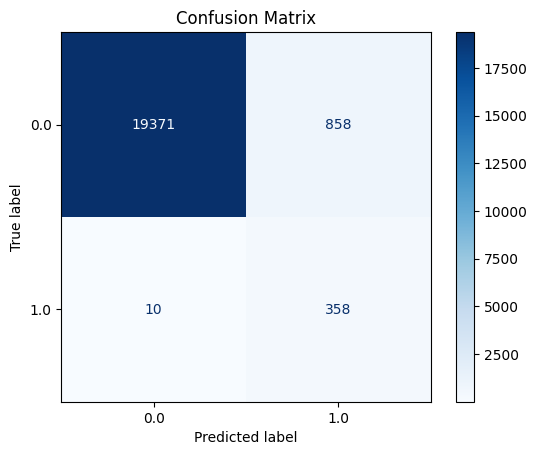

In [271]:
# Logistic Regression Classifier
clf = LogisticRegression(
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


In [62]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

X = train_df.drop(columns=['target'])
y = train_df['target']
print(f'Original minority percentage: {y.value_counts()[1]/len(y)*100:.2f}%')
scaler = StandardScaler()
x_scaled = X
x_scaled[dis_dates+value_cols] = scaler.fit_transform(X[dis_dates+value_cols])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)
print(f'Percentage of minority in training dataset before resampling: {y_train.value_counts()[1]/len(y_train)*100:.2f}%')

# sampling_pipeline = Pipeline([
#         ('undersampling', RandomUnderSampler(sampling_strategy=0.9)),
#         ('SMOTE', SMOTE(sampling_strategy=1.0))
#     ])

# rus = RandomUnderSampler(random_state=42, sampling_strategy=0.7)
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# X_train, y_train = sampling_pipeline.fit_resample(X_train, y_train)

print(f'Percentage of minority in training dataset after resampling: {y_train.value_counts()[1]/len(y_train)*100:.2f}%')

Original minority percentage: 1.83%
Percentage of minority in training dataset before resampling: 1.83%
Percentage of minority in training dataset after resampling: 50.00%


In [274]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

F1 Score: 0.5476
ROC AUC Score: 0.9929

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     20229
         1.0       0.39      0.95      0.55       368

    accuracy                           0.97     20597
   macro avg       0.69      0.96      0.77     20597
weighted avg       0.99      0.97      0.98     20597



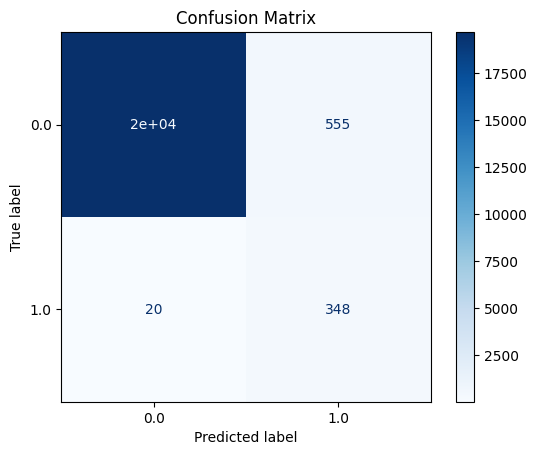

In [275]:
# Logistic Regression Classifier
clf = LogisticRegression(
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


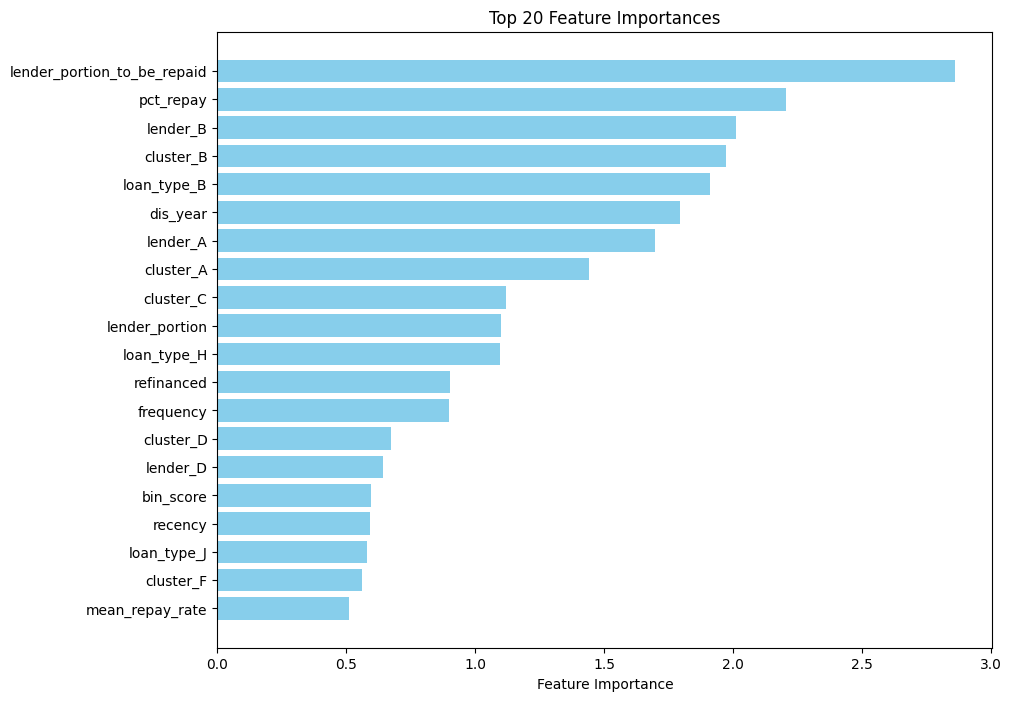

In [276]:
# Feature Importance

# Get the absolute values of the coefficients
feature_importances = np.abs(clf.coef_).flatten()

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

In [518]:
test_pred = clf.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_ids
sub['target'] = test_pred
sub.to_csv('sub0_logit_base.csv',index=False)

F1 Score: 0.7990
ROC AUC Score: 0.9188

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20229
         1.0       0.76      0.84      0.80       368

    accuracy                           0.99     20597
   macro avg       0.88      0.92      0.90     20597
weighted avg       0.99      0.99      0.99     20597



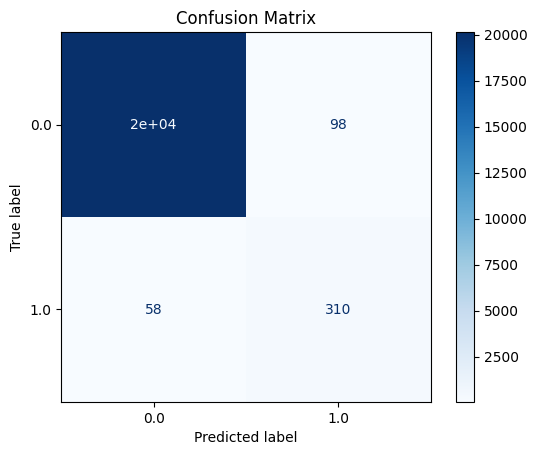

In [277]:
clf_tree = DecisionTreeClassifier(random_state=42)
clf_tree.fit(X_train, y_train)

# Predictions
y_pred = clf_tree.predict(X_test)
y_pred_proba = clf_tree.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf_tree.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


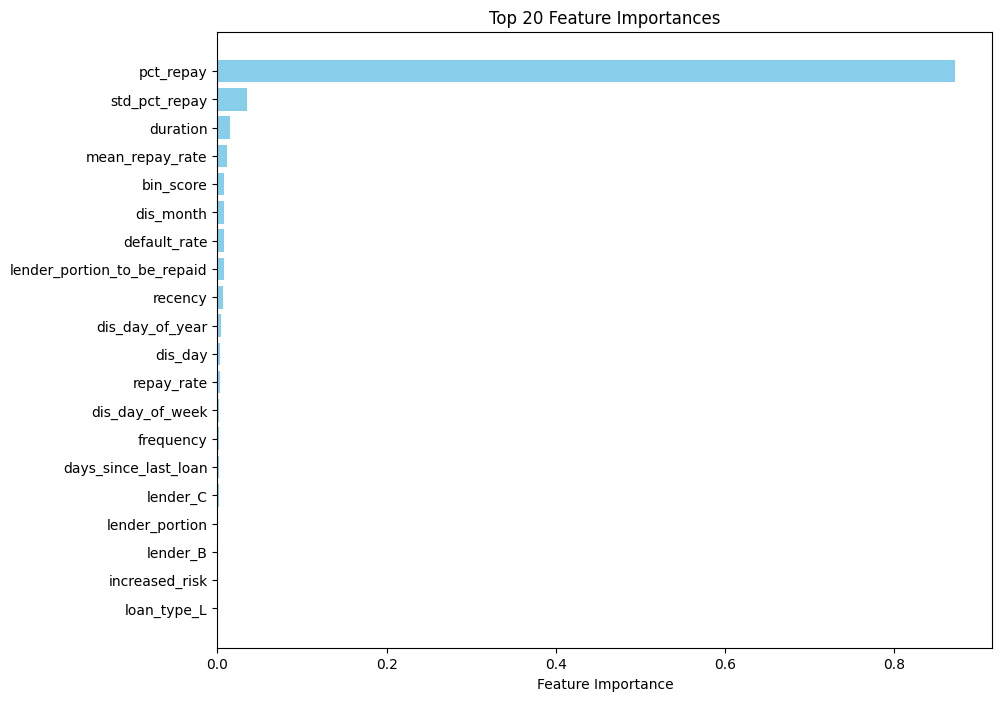

In [278]:
feature_importances = clf_tree.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

F1 Score: 0.8291
ROC AUC Score: 0.9968

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20229
         1.0       0.81      0.85      0.83       368

    accuracy                           0.99     20597
   macro avg       0.90      0.92      0.91     20597
weighted avg       0.99      0.99      0.99     20597



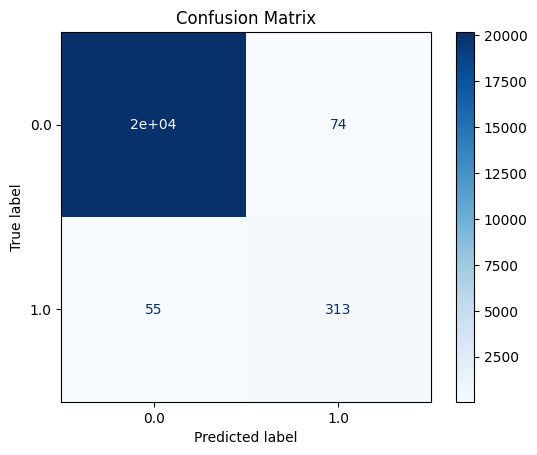

In [279]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()


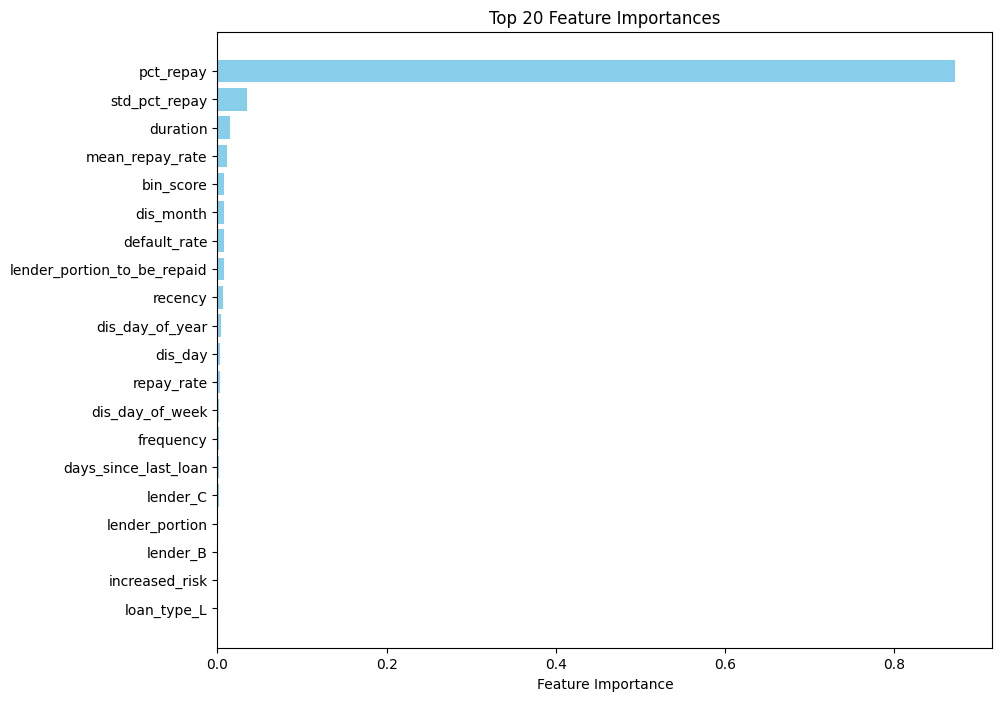

In [280]:
feature_importances = clf_tree.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

In [284]:
test_df

,id,customer_id,country_id,tbl_loan_id,lender_id,loan_type,duration,new,lender_portion,lender_portion_to_be_repaid,...,cluster_B,cluster_C,cluster_D,cluster_E,cluster_F,deposit_rate,inflation,exchange_rate,unemployment_rate,target
3,ID_245959104034245684,245959,Kenya,104034,lender_C,M,2.079442,0,0.693147,9.695664,...,0,0,0,1,0,2.039527,1.961212,4.706261,1.901062,0.0
6,ID_235173104603245684,235173,Kenya,104603,lender_C,L,3.433987,1,0.693147,8.585039,...,0,0,0,1,0,2.039527,1.961212,4.706261,1.901062,0.0
8,ID_25323104601245684,25323,Kenya,104601,lender_C,L,3.433987,1,0.693147,8.625509,...,0,0,0,1,0,2.039527,1.961212,4.706261,1.901062,0.0
13,ID_69751105198245684,69751,Kenya,105198,lender_C,O,3.433987,1,0.693147,9.315781,...,0,0,0,1,0,2.039527,1.961212,4.706261,1.901062,0.0
15,ID_230160105348245684,230160,Kenya,105348,lender_C,O,3.433987,1,0.693147,9.315781,...,0,0,0,1,0,2.039527,1.961212,4.706261,1.901062,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87231,ID_312159375304267278,312159,Kenya,375304,lender_A,H,2.079442,0,0.080043,6.063785,...,1,0,0,0,0,2.319215,2.160030,4.947670,1.899417,0.0
87232,ID_310986375306251804,310986,Kenya,375306,lender_B,H,2.079442,0,0.117783,6.655440,...,1,0,0,0,0,2.319215,2.160030,4.947670,1.899417,0.0
87235,ID_310743375320251804,310743,Kenya,375320,lender_B,R,2.079442,0,0.095310,8.537192,...,1,0,0,0,0,2.319215,2.160030,4.947670,1.899417,0.0
87237,ID_312159375304251804,312159,Kenya,375304,lender_B,H,2.079442,0,0.080043,6.063785,...,1,0,0,0,0,2.319215,2.160030,4.947670,1.899417,0.0


In [286]:
test_X = test_df.iloc[:, 6:].drop(columns=['target'])
test_X[dis_dates+value_cols] = scaler.fit_transform(test_X[dis_dates+value_cols])


In [287]:
test_X

,duration,new,lender_portion,lender_portion_to_be_repaid,pct_repay,repay_rate,dis_year,dis_month,dis_day,dis_day_of_week,...,cluster_A,cluster_B,cluster_C,cluster_D,cluster_E,cluster_F,deposit_rate,inflation,exchange_rate,unemployment_rate
3,-0.226658,0,4.966244,1.409072,0.191920,1.151558,-2.730880,1.127125,-0.961034,-1.434530,...,0,0,0,0,1,0,-0.852275,-0.858035,0.400961,0.405717
6,2.107799,1,4.966244,0.973557,0.614839,-1.124919,-2.730880,1.127125,0.189860,0.210232,...,0,0,0,0,1,0,-0.852275,-0.858035,0.400961,0.405717
8,2.107799,1,4.966244,0.989427,1.257313,-1.089133,-2.730880,1.127125,0.189860,0.210232,...,0,0,0,0,1,0,-0.852275,-0.858035,0.400961,0.405717
13,2.107799,1,4.966244,1.260107,1.212693,-0.477817,-2.730880,1.127125,0.765307,-0.886276,...,0,0,0,0,1,0,-0.852275,-0.858035,0.400961,0.405717
15,2.107799,1,4.966244,1.260107,1.212693,-0.477817,-2.730880,1.127125,0.880396,-0.338022,...,0,0,0,0,1,0,-0.852275,-0.858035,0.400961,0.405717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87231,-0.226658,0,-1.002326,-0.015114,0.096433,0.130084,4.695698,1.127125,-0.270498,0.210232,...,0,1,0,0,0,0,0.673036,-0.479242,0.644166,0.397481
87232,-0.226658,0,-0.634930,0.216895,0.098773,0.297434,4.695698,1.127125,-0.270498,0.210232,...,0,1,0,0,0,0,0.673036,-0.479242,0.644166,0.397481
87235,-0.226658,0,-0.853703,0.954795,-0.128691,2.168230,4.695698,1.127125,-0.270498,0.210232,...,0,1,0,0,0,0,0.673036,-0.479242,0.644166,0.397481
87237,-0.226658,0,-1.002326,-0.015114,0.096433,0.130084,4.695698,1.127125,-0.270498,0.210232,...,0,1,0,0,0,0,0.673036,-0.479242,0.644166,0.397481


In [288]:
test_pred = clf.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_df['id']
sub['target'] = test_pred

In [289]:
sub.to_csv('sub1_rf_base.csv',index=False)

F1 Score: 0.8725
ROC AUC Score: 0.9976

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20229
         1.0       0.86      0.88      0.87       368

    accuracy                           1.00     20597
   macro avg       0.93      0.94      0.94     20597
weighted avg       1.00      1.00      1.00     20597



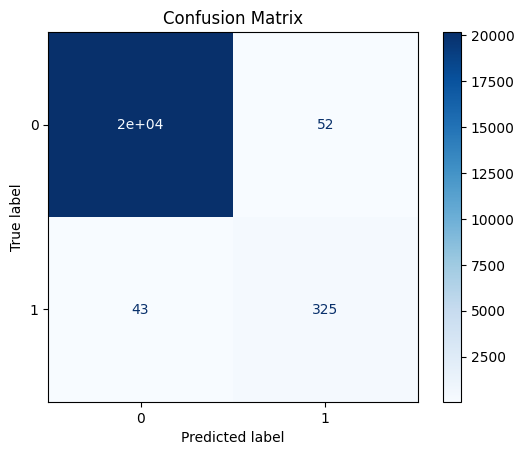

In [290]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model = xgb_clf.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=model.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

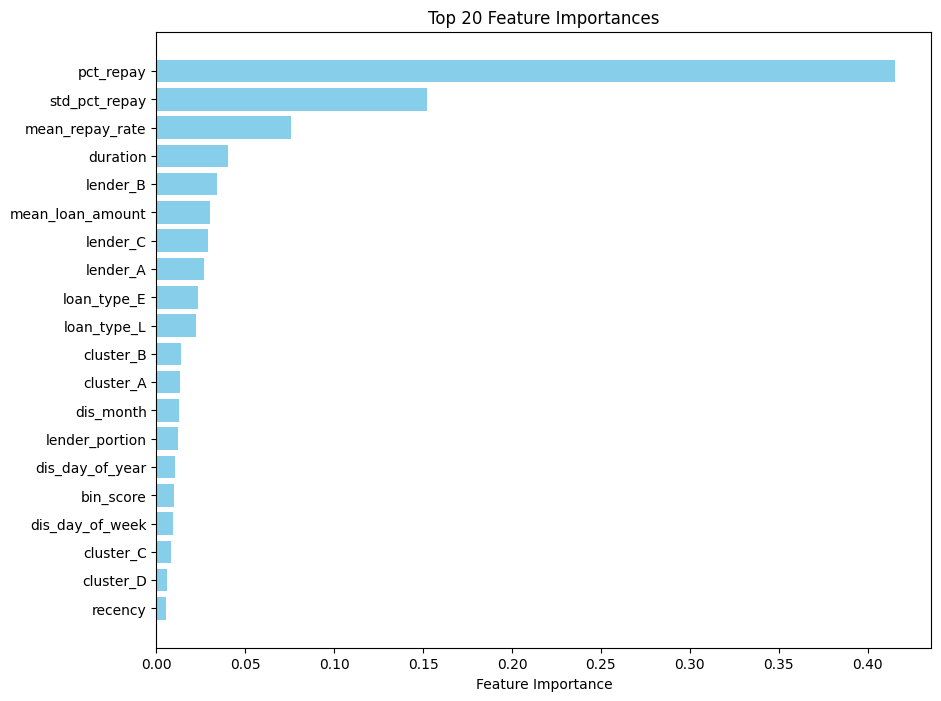

In [291]:
feature_importances = model.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

In [292]:
test_pred = model.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_df['id']
sub['target'] = test_pred
sub.to_csv('sub2_xgb_base.csv',index=False)

In [ ]:
model = xgb_clf.fit(x_scaled.iloc[:, 6:], y)
test_pred = model.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_ids
sub['target'] = test_pred
sub.to_csv('sub3_xgb_base.csv',index=False)

In [90]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import xgboost as xgb


In [91]:
import xgboost as xgb
import sklearn

print(f"XGBoost version: {xgb.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")


XGBoost version: 2.1.3
Scikit-learn version: 1.6.0


In [294]:
from imblearn.over_sampling import SMOTE

X = train_df.iloc[:, 6:].drop(columns=['target'])
y = train_df['target']

scaler = StandardScaler()
x_scaled = X
x_scaled[dis_dates+value_cols] = scaler.fit_transform(X[dis_dates+value_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
# smote = SMOTE(random_state=42, sampling_strategy='minority')
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [295]:
from xgboost import cv
import xgboost as xgb

def f1_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = np.round(preds)  # Convert probabilities to binary (0 or 1)
    f1 = f1_score(labels, preds_binary)
    return 'f1', f1

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 50, 'alpha': 1, 'lambda':10}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=5,
                    num_boost_round=500, early_stopping_rounds=10, custom_metric=f1_eval, maximize=True, as_pandas=True, seed=42)

In [296]:
xgb_cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std,train-f1-mean,train-f1-std,test-f1-mean,test-f1-std
0,0.152678,0.000917,0.152889,0.003079,0.000000,0.000000,0.000000,0.000000
1,0.141096,0.000879,0.141567,0.003058,0.000000,0.000000,0.000000,0.000000
2,0.127075,0.000786,0.127608,0.002726,0.000000,0.000000,0.000000,0.000000
3,0.117751,0.000777,0.118592,0.002728,0.000000,0.000000,0.000000,0.000000
4,0.110611,0.000801,0.111570,0.002817,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
129,0.008262,0.000186,0.014327,0.001272,0.952897,0.004459,0.842388,0.020548
130,0.008177,0.000187,0.014259,0.001265,0.953465,0.004266,0.844082,0.020055
131,0.008101,0.000189,0.014183,0.001250,0.953067,0.004363,0.845593,0.020202
132,0.008033,0.000189,0.014125,0.001244,0.953354,0.004378,0.846180,0.019308


In [297]:
best_num_boost_rounds = len(xgb_cv)  # This gives the number of rounds based on early stopping

# Final DMatrix for training
data_dmatrix = xgb.DMatrix(data=X_train, label=y_train)

# Train the final model
final_model = xgb.train(
    params=params,
    dtrain=data_dmatrix,
    num_boost_round=best_num_boost_rounds
)

In [298]:
# Convert test features to DMatrix
test_dmatrix = xgb.DMatrix(data=X_test)

# Predict probabilities
pred_probs = final_model.predict(test_dmatrix)

# Convert probabilities to binary predictions (0 or 1)
preds = [1 if prob > 0.5 else 0 for prob in pred_probs]


F1 Score: 0.8781302170283807
Accuracy: 0.9957469121416919
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16849
         1.0       0.93      0.83      0.88       315

    accuracy                           1.00     17164
   macro avg       0.96      0.92      0.94     17164
weighted avg       1.00      1.00      1.00     17164



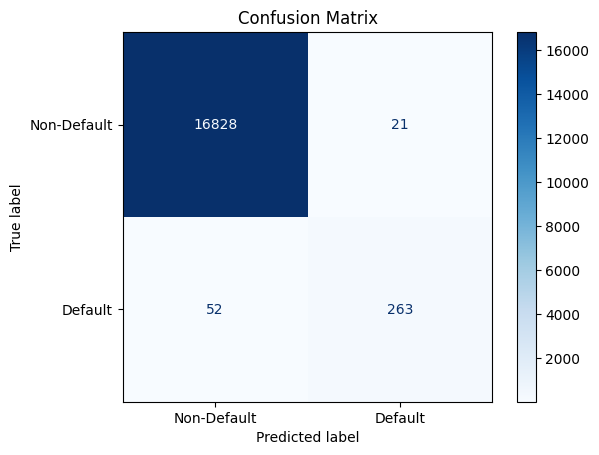

In [299]:
print("F1 Score:", f1_score(y_test, preds))
print("Accuracy:", accuracy_score(y_test, preds))
print("Classification Report:\n", classification_report(y_test, preds))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    preds,
    display_labels=["Non-Default", "Default"],
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

In [238]:
X = train_df.drop(columns=['target'])
y = train_df['target']

scaler = StandardScaler()
X_scaled = X
X_scaled[dis_dates] = scaler.fit_transform(X[dis_dates])
# smote = SMOTE(random_state=42, sampling_strategy='minority')
# X_scaled, y = smote.fit_resample(X_scaled, y)

In [104]:
data_dmatrix = xgb.DMatrix(data=X_scaled, label=y)

# Train the final model
final_model = xgb.train(
    params=params,
    dtrain=data_dmatrix,
    num_boost_round=best_num_boost_rounds
)

In [301]:
test_dmatrix = xgb.DMatrix(data=test_X)

# Predict probabilities
pred_probs = final_model.predict(test_dmatrix)

# Convert probabilities to binary predictions (0 or 1)
preds = [1 if prob > 0.5 else 0 for prob in pred_probs]

In [302]:
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_df['id']
sub['target'] = preds
sub.to_csv('sub3_xgb_tuned.csv',index=False)

In [303]:
from lightgbm import LGBMClassifier

In [304]:
lgb = LGBMClassifier(random_state=42,
                     objective='binary',
                     learning_rate=0.1,
                     max_depth=50,
                     reg_alpha=0.1,
                     reg_lambda=0.1,)

In [307]:
lgb.fit(X_train,y_train)

[LightGBM] [Info] Number of positive: 943, number of negative: 50547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004664 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 51490, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018314 -> initscore=-3.981593
[LightGBM] [Info] Start training from score -3.981593


LGBMClassifier(max_depth=50, objective='binary', random_state=42, reg_alpha=0.1,
               reg_lambda=0.1)

F1 Score: 0.8833
ROC AUC Score: 0.9974

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16849
         1.0       0.93      0.84      0.88       315

    accuracy                           1.00     17164
   macro avg       0.96      0.92      0.94     17164
weighted avg       1.00      1.00      1.00     17164



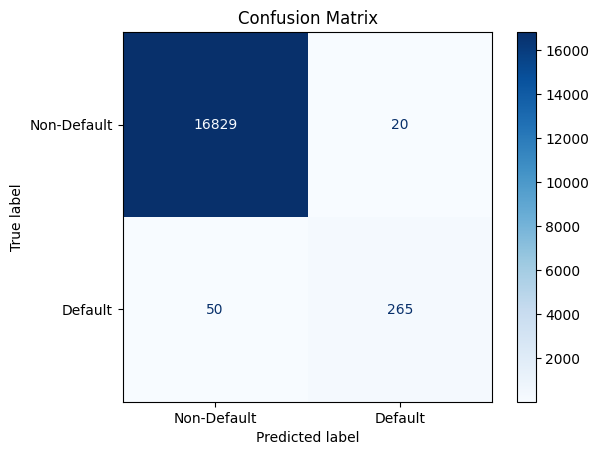

In [308]:
y_pred = lgb.predict(X_test)
y_pred_proba = lgb.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["Non-Default", "Default"],
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

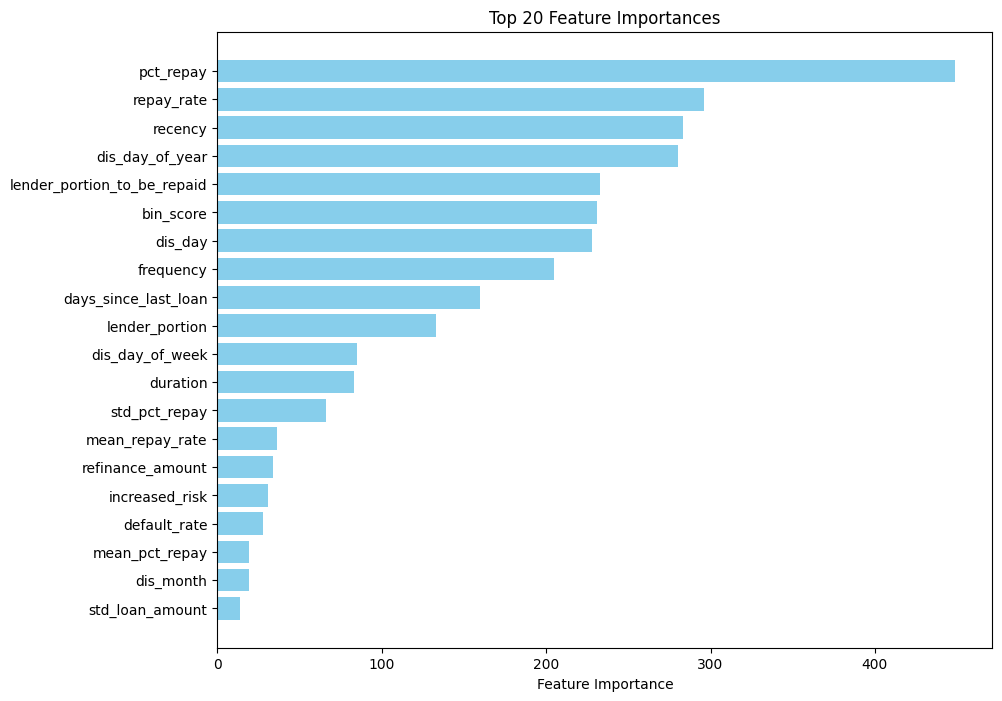

In [309]:
feature_importances = lgb.feature_importances_

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

In [310]:
# model = lgb.fit(x_scaled, y)
test_pred = lgb.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_df['id']
sub['target'] = test_pred
sub.to_csv('sub4_lgb_base.csv',index=False)

In [311]:
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import xgboost as xgb
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

In [312]:
params = {'subsample': 0.5, 'scale_pos_weight': 53.59542743538768, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'max_delta_step': 3, 'learning_rate': 0.3, 'gamma': 0.5, 'colsample_bytree': 0.5}


In [313]:
clf = LogisticRegression(
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lgb = LGBMClassifier(random_state=42, **params)
# xgb = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create a Voting Classifier (hard voting or soft voting)
voting_clf = VotingClassifier(
    estimators=[
        ('rf', rf),
        ('lgb', lgb),
        ('clf', clf)
    ],
    weights=[2,1,1],
    voting='soft'  # 'soft' for predicted probabilities, 'hard' for majority vote
)

# Fit the voting classifier on the training data
voting_clf.fit(X_train, y_train)

# Predict and evaluate
voting_preds = voting_clf.predict(X_test)


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Info] Number of positive: 943, number of negative: 50547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 51490, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018314 -> initscore=-3.981593
[LightGBM] [Info] Start training from score -3.981593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive

Voting Classifier Accuracy: 0.9962712654392916
Voting Classifier F1 Score: 0.8996865203761756
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16849
         1.0       0.89      0.91      0.90       315

    accuracy                           1.00     17164
   macro avg       0.94      0.95      0.95     17164
weighted avg       1.00      1.00      1.00     17164



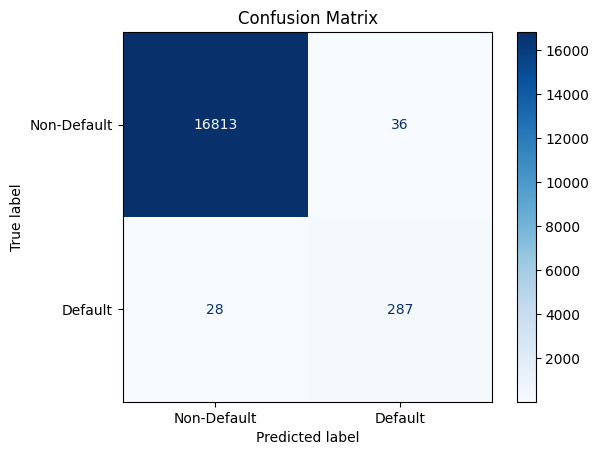

In [315]:
print("Voting Classifier Accuracy:", accuracy_score(y_test, voting_preds))
print("Voting Classifier F1 Score:", f1_score(y_test, voting_preds))
print("Classification Report:\n", classification_report(y_test, voting_preds))

ConfusionMatrixDisplay.from_predictions(
    y_test,
    voting_preds,
    display_labels=["Non-Default", "Default"],
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

In [316]:
def compute_feature_importance(voting_clf, weights):
    """ Function to compute feature importance of Voting Classifier """
    
    feature_importance = dict()
    for est in voting_clf.estimators_:
        if isinstance(est, LogisticRegression):
            feature_importance[str(est)] = np.abs(est.coef_).flatten()
        else:
            feature_importance[str(est)] = est.feature_importances_
    
    fe_scores = [0]*len(list(feature_importance.values())[0])
    for idx, imp_score in enumerate(feature_importance.values()):
        imp_score_with_weight = imp_score*weights[idx]
        fe_scores = list(np.add(fe_scores, list(imp_score_with_weight)))
    return fe_scores

In [317]:
weights = voting_clf.weights

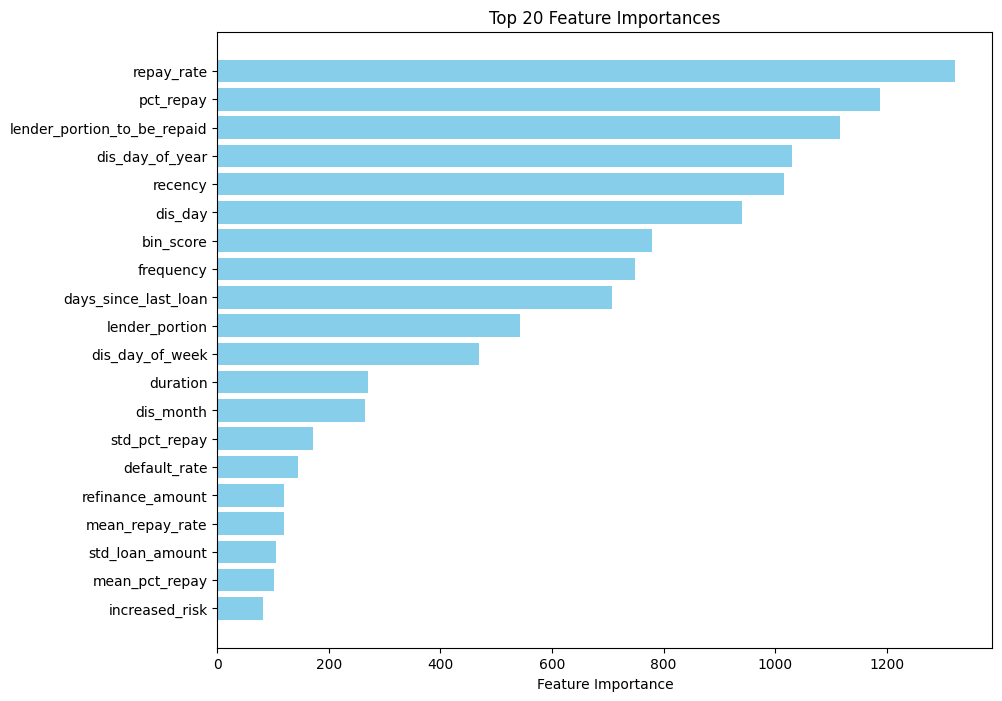

In [318]:
feature_importances = compute_feature_importance(voting_clf,weights)

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

In [319]:
# model = voting_clf.fit(x_scaled, y)
test_pred = voting_clf.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_df['id']
sub['target'] = test_pred
sub.to_csv('sub5_voting_base.csv',index=False)

[LightGBM] [Warning] Unknown parameter: gamma


In [320]:
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator, ClassifierMixin

class XGBWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, **params):
        self.model = XGBClassifier(**params)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        self.classes_ = self.model.classes_
        return self

    def predict(self, X):
        return self.model.predict(X)

    def predict_proba(self, X):
        return self.model.predict_proba(X)

# Use the wrapper in the stacking classifier
xgb = XGBWrapper(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')


In [321]:

from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

# Base models
rf = RandomForestClassifier(n_estimators=100, random_state=42)
lgb = LGBMClassifier(n_estimators=100, random_state=42)

# Meta-model
meta_model = LogisticRegression()

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=[
        ('rf', rf),
        ('lgb', lgb),
        # ('xgb', xgb)  # Using the wrapped XGBoost
    ],
    final_estimator=meta_model,
    cv=5
)

# Fit and evaluate
stacking_clf.fit(X_train, y_train)
stacking_preds = stacking_clf.predict(X_test)

print("Accuracy:", accuracy_score(y_test, stacking_preds))


[LightGBM] [Info] Number of positive: 943, number of negative: 50547
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2678
[LightGBM] [Info] Number of data points in the train set: 51490, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.018314 -> initscore=-3.981593
[LightGBM] [Info] Start training from score -3.981593
[LightGBM] [Info] Number of positive: 755, number of negative: 40437
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.039533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2649
[LightGBM] [Info] Number of data points in the train set: 41192, number of used features: 48
[LightGBM] [Info] [bin

Stacked Classifier Accuracy: 0.9955721277091587
Stacked Classifier F1 Score: 0.8711864406779661
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16849
         1.0       0.93      0.82      0.87       315

    accuracy                           1.00     17164
   macro avg       0.97      0.91      0.93     17164
weighted avg       1.00      1.00      1.00     17164



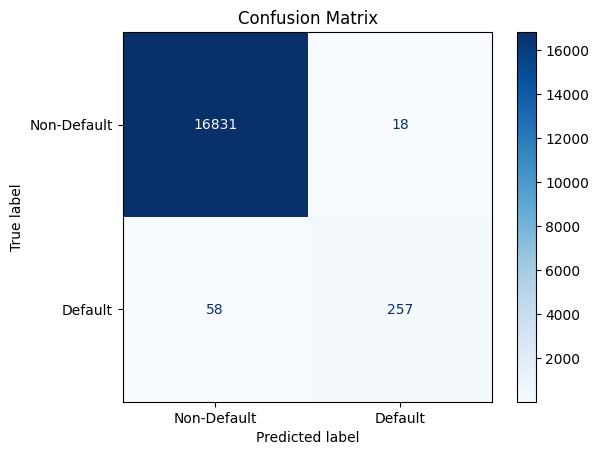

In [323]:
print("Stacked Classifier Accuracy:", accuracy_score(y_test, stacking_preds))
print("Stacked Classifier F1 Score:", f1_score(y_test, stacking_preds))
print("Classification Report:\n", classification_report(y_test, stacking_preds))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    stacking_preds,
    display_labels=["Non-Default", "Default"],
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

In [324]:
feature_importances = compute_feature_importance(voting_clf, [1, 1])

importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False).head(20)

# Plot the top 20 feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances')
plt.show()

IndexError: list index out of range

In [465]:
# model = stacking_clf.fit(x_scaled, y)
test_pred = stacking_clf.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_ids
sub['target'] = test_pred
sub.to_csv('sub6_stack_base.csv',index=False)

KNN Classifier Accuracy: 0.9906199021207178
KNN Classifier F1 Score: 0.7034990791896869
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     16849
         1.0       0.84      0.61      0.70       315

    accuracy                           0.99     17164
   macro avg       0.92      0.80      0.85     17164
weighted avg       0.99      0.99      0.99     17164



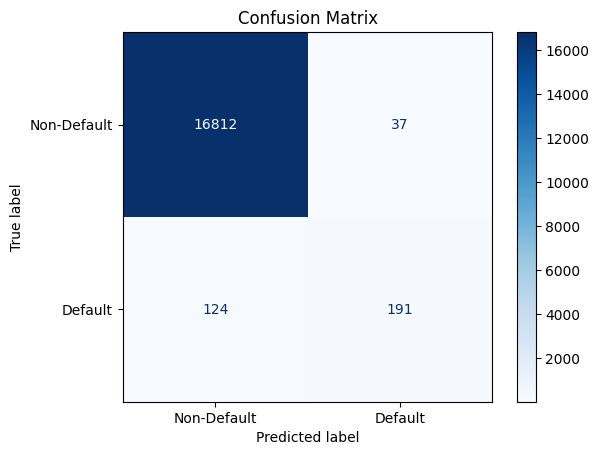

In [325]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5, weights='uniform')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

print("KNN Classifier Accuracy:", accuracy_score(y_test, y_pred))
print("KNN Classifier F1 Score:", f1_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["Non-Default", "Default"],
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

In [72]:
value_cols + ['target']

['total_amount',
 'total_amount_to_repay',
 'duration',
 'amount_funded_by_lender',
 'lender_portion_funded',
 'lender_portion_to_be_repaid',
 'pct_repay',
 'monetary',
 'recency',
 'frequency',
 'inflation',
 'deposit_rate',
 'exchange_rate',
 'unemployment_rate',
 'target']

In [326]:
corr_matrix = train_df[value_cols + dis_dates + ['target']].corr()

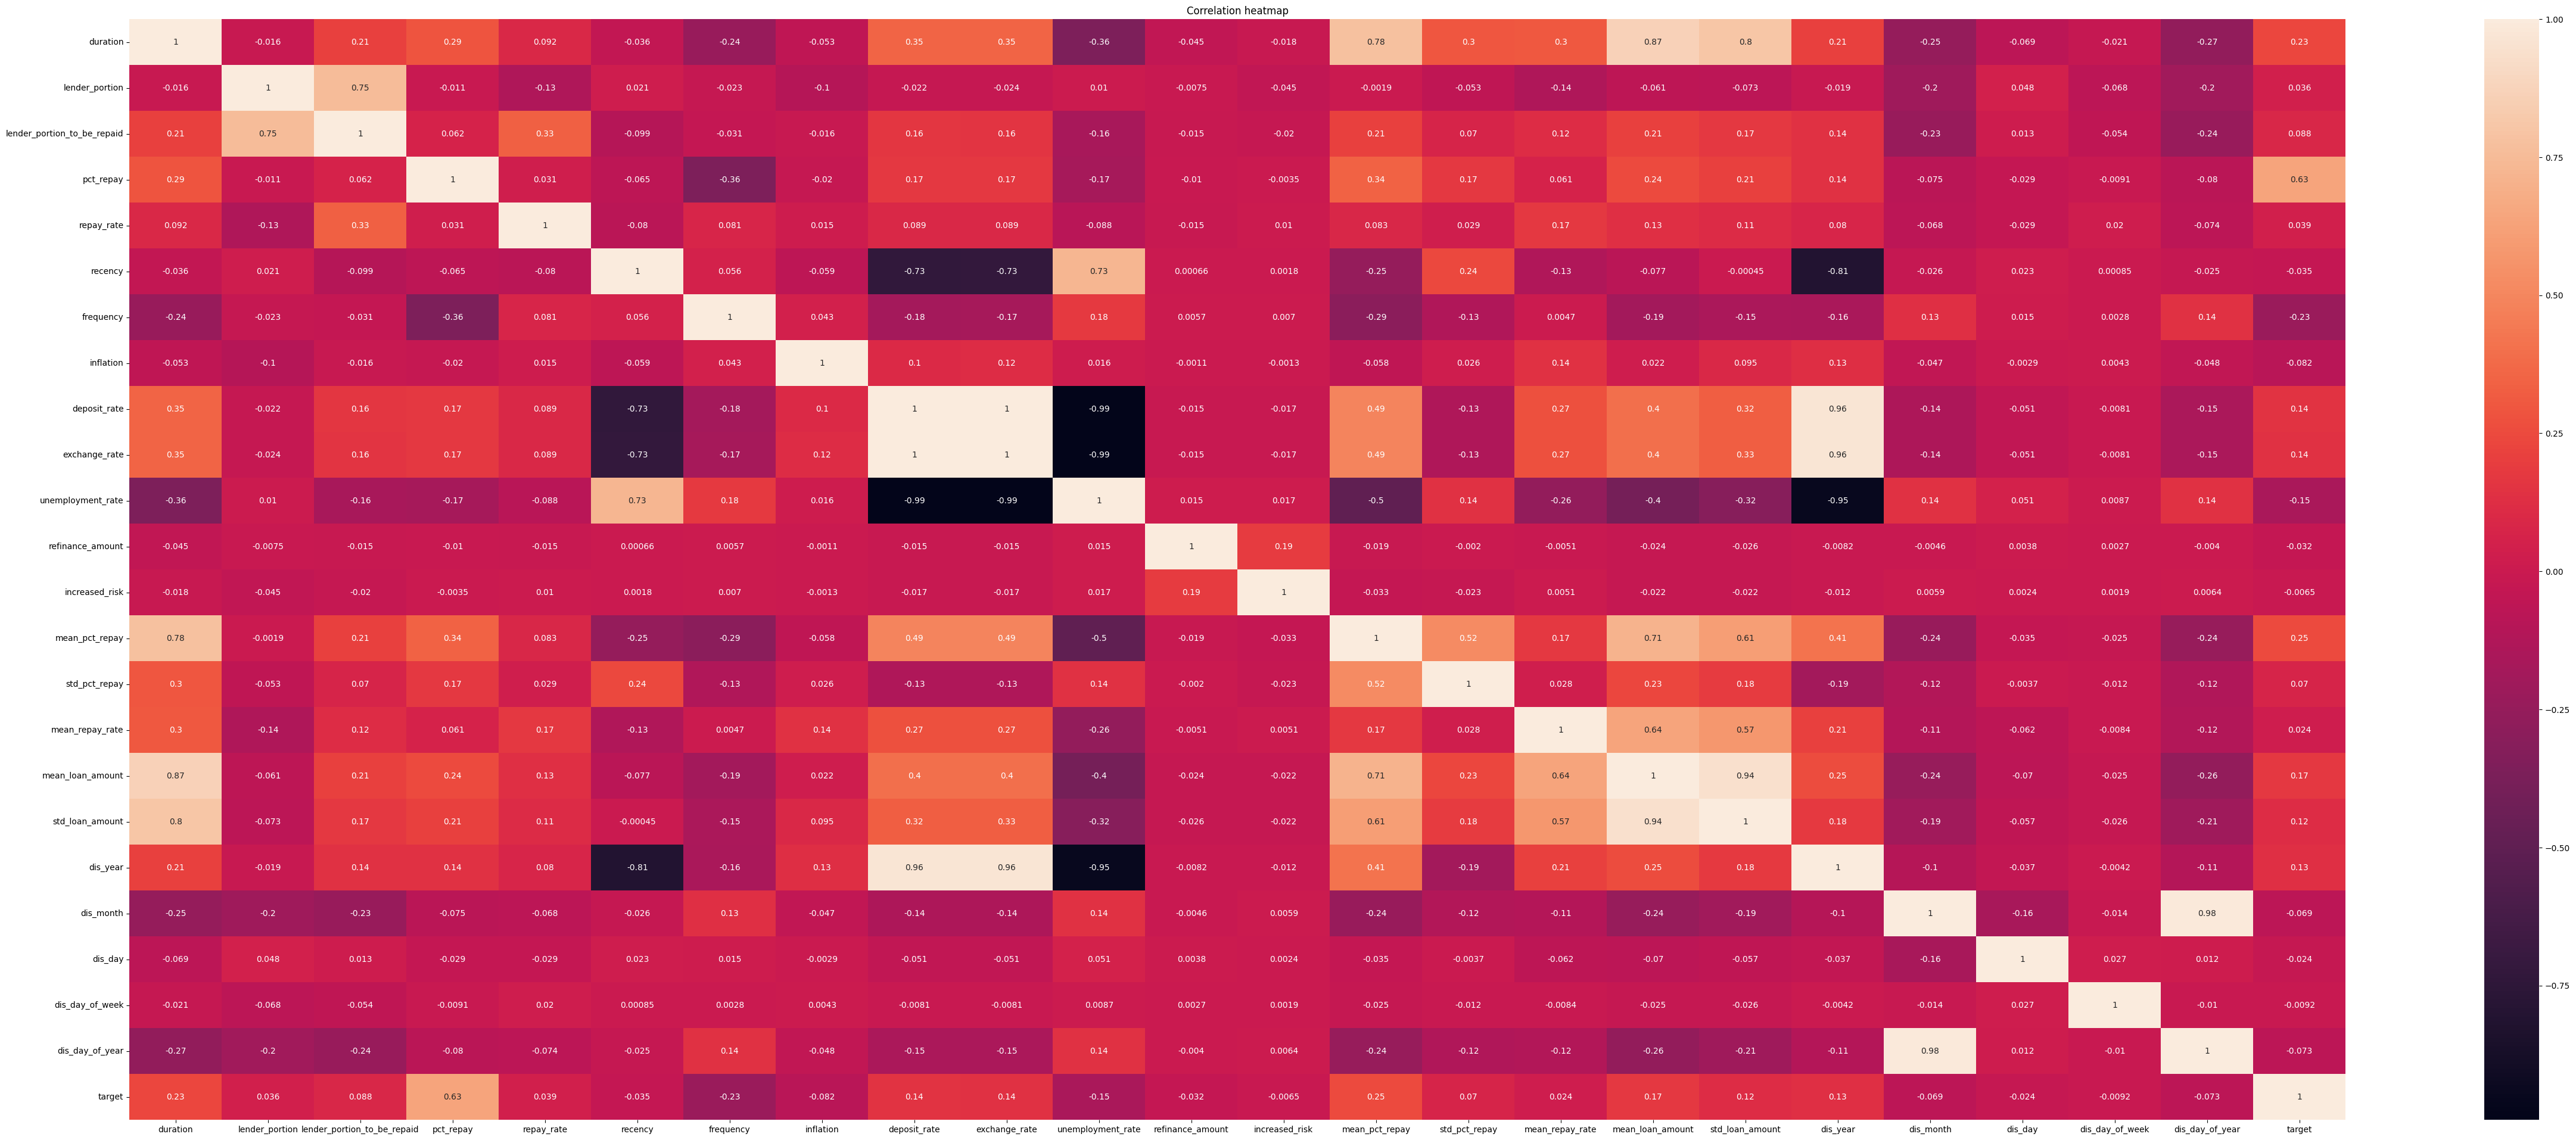

In [327]:
# corr_matrix = df.corr()

plt.figure(figsize =(60, 24))
sns.heatmap(corr_matrix, annot=True)
plt.title('Correlation heatmap')
plt.show()

In [330]:
X.iloc[:, 6:]

,duration,new,lender_portion,lender_portion_to_be_repaid,pct_repay,repay_rate,dis_year,dis_month,dis_day,dis_day_of_week,...,cluster_A,cluster_B,cluster_C,cluster_D,cluster_E,cluster_F,deposit_rate,inflation,exchange_rate,unemployment_rate
0,4.045887,1,4.562066,1.164747,0.566960,-0.608637,-2.596048,0.746449,-1.414690,-1.391510,...,0,0,0,0,1,0,-1.342393,-41.848549,-2.014498,-3.522028
1,1.769512,1,4.562066,1.174937,1.145056,0.055591,-2.596048,0.746449,-0.383409,-0.276678,...,0,0,1,0,0,0,-1.342393,-41.848549,-2.014498,-3.522028
2,-0.201663,0,4.562066,1.322620,0.399878,0.982419,-2.596048,0.746449,-0.268822,0.280738,...,0,0,0,0,1,0,-1.342393,-41.848549,-2.014498,-3.522028
4,4.045887,0,4.562066,0.415128,3.295019,-2.337841,-2.596048,1.359558,-0.039648,-0.834094,...,0,0,0,0,1,0,-1.342393,-41.848549,-2.014498,-3.522028
5,4.045887,1,4.562066,0.935514,1.794001,-1.140256,-2.596048,1.359558,0.189525,0.280738,...,0,0,0,0,1,0,-1.342393,-41.848549,-2.014498,-3.522028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87243,-0.201663,0,-1.017646,0.325547,-0.018847,0.752857,4.458338,1.359558,-0.268822,0.280738,...,0,1,0,0,0,0,3.911149,0.288561,3.909020,-3.896571
87244,-0.201663,0,-0.674234,0.222883,0.277990,0.173281,4.458338,1.359558,-0.268822,0.280738,...,0,1,0,0,0,0,3.911149,0.288561,3.909020,-3.896571
87245,-0.201663,0,-0.674234,0.402317,-0.019659,0.590660,4.458338,1.359558,-0.268822,0.280738,...,0,1,0,0,0,0,3.911149,0.288561,3.909020,-3.896571
87246,-0.201663,0,-0.878710,0.537854,0.275413,1.094195,4.458338,1.359558,-0.268822,0.280738,...,0,1,0,0,0,0,3.911149,0.288561,3.909020,-3.896571


In [331]:
from sklearn.decomposition import PCA

X = train_df.drop(columns=['target'])
y = train_df['target']

scaler = StandardScaler()
X_scaled = X.iloc[:, 6:]
X_scaled[value_cols+dis_dates] = scaler.fit_transform(X[value_cols+dis_dates])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Initialize PCA with the number of components set to the number of features
pca = PCA()
X_pca = pca.fit_transform(X_train)

# Check the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print cumulative explained variance
import numpy as np
cumulative_variance = np.cumsum(explained_variance_ratio)
print("Cumulative Explained Variance:", cumulative_variance)


Cumulative Explained Variance: [0.94745405 0.96140677 0.96871485 0.97363199 0.97737402 0.98076928
 0.98346515 0.98582632 0.98811978 0.99037762 0.99254868 0.99460459
 0.99607334 0.99744487 0.99818676 0.99868702 0.99899004 0.99925538
 0.99946912 0.99959787 0.9996813  0.99974714 0.99979455 0.99984089
 0.99988447 0.99991181 0.99993183 0.99994818 0.99996057 0.99997099
 0.9999774  0.99998247 0.99998597 0.99998885 0.99999133 0.99999316
 0.9999945  0.99999564 0.99999652 0.99999728 0.99999793 0.9999984
 0.99999883 0.99999917 0.99999937 0.99999954 0.9999997  0.99999983
 0.99999988 0.99999992 0.99999996 0.99999999 0.99999999 1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


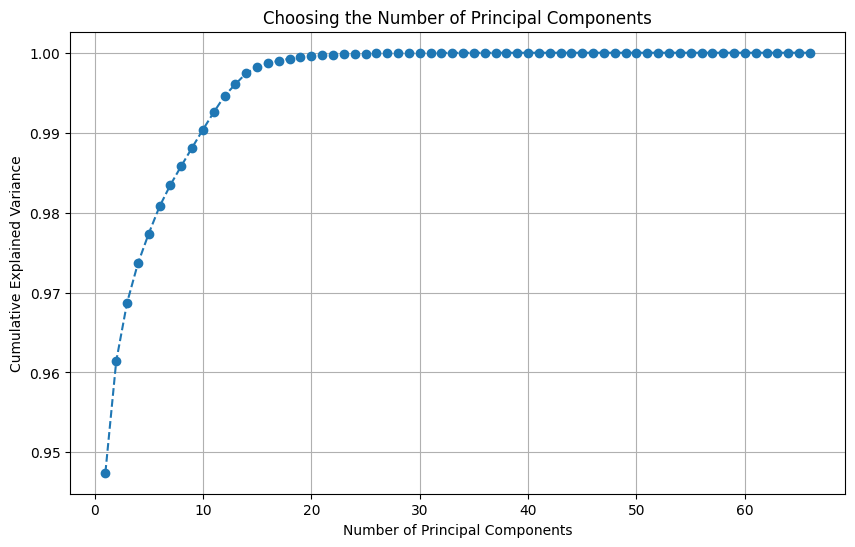

In [332]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Choosing the Number of Principal Components')
plt.grid()
plt.show()


In [333]:
# Choose optimal number of components, e.g., 5
optimal_n_components = 20
pca_optimal = PCA(n_components=optimal_n_components)
X_pca_optimal = pca_optimal.fit_transform(X_train)

print(f"Shape of reduced data: {X_pca_optimal.shape}")


Shape of reduced data: (54923, 20)


In [335]:
loadings = pca_optimal.components_
feature_names = X_scaled.columns

# Create a DataFrame for better readability
import pandas as pd
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(optimal_n_components)], index=feature_names)

print("Feature Loadings:")
print(loadings_df)


Feature Loadings:
                                      PC1       PC2           PC3  \
duration                     1.208234e-02  0.259873  3.146589e-01   
new                         -1.285507e-04  0.003613  1.234459e-04   
lender_portion              -1.669219e-03  0.010943  6.283731e-02   
lender_portion_to_be_repaid  2.017456e-03  0.118677  1.227886e-01   
pct_repay                    5.390355e-03  0.118970  1.072817e-01   
repay_rate                   1.780695e-03  0.066209  5.206010e-02   
dis_year                     7.700962e-03  0.328496 -3.067351e-01   
dis_month                   -8.902819e-04 -0.134046 -2.321070e-01   
dis_day                     -6.622382e-04 -0.024387  2.955290e-03   
dis_day_of_week             -6.216613e-04 -0.007175 -1.250844e-02   
dis_day_of_year             -9.756034e-04 -0.138612 -2.358707e-01   
days_since_last_loan         9.995162e-01 -0.028878 -6.137309e-03   
refinanced                   1.952153e-03  0.083963 -3.529927e-02   
refinance_amount

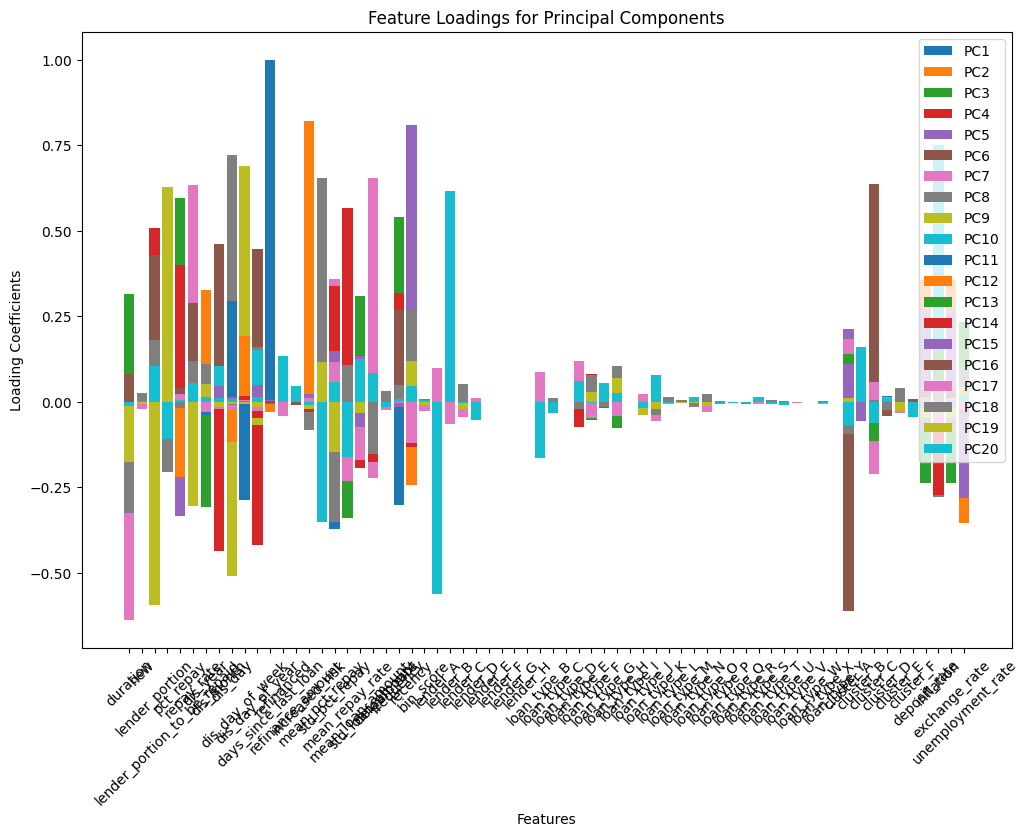

In [336]:
plt.figure(figsize=(12, 8))
for i in range(optimal_n_components):
    plt.bar(loadings_df.index, loadings_df[f'PC{i+1}'], label=f'PC{i+1}')

plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Loading Coefficients')
plt.title('Feature Loadings for Principal Components')
plt.legend()
plt.show()


In [337]:
# Reconstruct the data
X_reconstructed = pca_optimal.inverse_transform(X_pca_optimal)

# Compare reconstruction error
reconstruction_error = np.mean((X_train - X_reconstructed) ** 2)
print(f'Reconstruction Error: {reconstruction_error}')


Reconstruction Error: 0.0025981081692072745


In [172]:
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train, y_train = smote.fit_resample(X_pca_optimal, y_train)

In [173]:
X_test = pca_optimal.transform(X_test)

In [136]:
X = train_df.drop(columns=['target'])
y = train_df['target']
scaler = StandardScaler()
x_scaled = X
x_scaled[value_cols+dis_dates] = scaler.fit_transform(X[value_cols+dis_dates])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [201]:
from sklearn.model_selection import StratifiedKFold

X = train_df.drop(columns=['target'])
y = train_df['target']

scaler = StandardScaler()
X_scaled = X
X_scaled[value_cols+dis_dates] = scaler.fit_transform(X[value_cols+dis_dates])

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)
for train_index, test_index in sss.split(X_scaled, y):
    original_Xtrain, original_Xtest = X_scaled.iloc[train_index], X_scaled.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Check the Distribution of the labels

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

# scaler = StandardScaler()
# x_scaled = X
# x_scaled[value_cols+dis_dates] = scaler.fit_transform(X[value_cols+dis_dates])

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# smote = SMOTE(random_state=42, sampling_strategy='minority')
# X_train, y_train = smote.fit_resample(X_train, y_train)

# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [349]:
def create_risk_features(df):
    # Risk score combining multiple risk indicators
    df['risk_score'] = (
        df['default_rate'] * 0.4 +
        df['std_pct_repay'] * 0.3 +
        (1 - df['mean_repay_rate']) * 0.3
    )
    
    # Risk change indicators
    df['risk_trend'] = df['increased_risk'] / df['mean_loan_amount']
    df['repayment_volatility'] = df['std_pct_repay'] / df['mean_pct_repay']
    
    return df

In [360]:
def create_temporal_features(df):
    # Seasonality
    df['is_weekend'] = df['dis_day_of_week'].isin([5, 6]).astype(int)
    # df['quarter'] = pd.to_datetime(df[['dis_year', 'dis_month', 'dis_day']]).dt.quarter
    
    # Loan velocity
    df['loan_frequency_monthly'] = df['frequency'] / df['recency']
    
    # Time since first loan (using recency and frequency)
    df['customer_tenure'] = df['recency'] / df['frequency']
    
    return df

In [361]:
def create_economic_features(df):
    # Economic pressure indicator
    df['economic_pressure'] = (
        df['inflation'] * 0.4 +
        df['unemployment_rate'] * 0.4 +
        (1 - df['deposit_rate']) * 0.2
    )
    
    # Exchange rate volatility (if you have historical data)
    df['exchange_risk'] = df['exchange_rate'] * df['mean_loan_amount']
    
    return df

In [362]:
def create_behavioral_features(df):
    # Loan preference
    df['prefers_long_duration'] = (df['duration'] > df['duration'].median()).astype(int)
    
    # Refinancing behavior
    df['refinance_ratio'] = df['refinance_amount'] / df['mean_loan_amount']
    
    # Lender diversity (using dummy variables)
    # lender_cols = [col for col in df.columns if col.startswith('lender_')]
    # df['lender_diversity'] = df[lender_cols].sum(axis=1)
    
    return df

In [363]:
def create_composite_features(df):
    # Overall risk profile
    df['risk_profile'] = (
        df['bin_score'] * 0.3 +
        df['default_rate'] * 0.4 +
        (1 - df['mean_pct_repay']) * 0.3
    )
    
    # Customer value score
    df['customer_value'] = (
        df['frequency'] * 0.3 +
        df['mean_loan_amount'] * 0.4 +
        df['mean_repay_rate'] * 0.3
    )
    
    # Loan complexity
    loan_type_cols = [col for col in df.columns if col.startswith('loan_type_')]
    df['loan_complexity'] = df[loan_type_cols].sum(axis=1)
    
    return df

In [369]:
def engineer_features(df):
    df = create_risk_features(df)
    df = create_temporal_features(df)
    df = create_economic_features(df)
    df = create_behavioral_features(df)
    df = create_composite_features(df)
    
    return df

In [374]:
df = engineer_features(df)

scaler = StandardScaler()
numeric_features = [col for col in df.columns if df[col].dtype in ['float64', 'int64'] and col != 'target']
for col in numeric_features:
    # Replace inf with max value
    df[col] = df[col].replace([np.inf, -np.inf], np.nan)
    # Fill NaN with median
    df[col] = df[col].fillna(df[col].median())
    # Clip extreme values
    upper_bound = df[col].quantile(0.99)
    lower_bound = df[col].quantile(0.01)
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

train_df = df[df['id'].isin(train_ids)]
test_df = df[df['id'].isin(test_ids)]

X = train_df.drop(columns=['target'])
y = train_df['target']
X_scaled = X
X_scaled[numeric_features] = scaler.fit_transform(X[numeric_features])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Lists to store cross-validation results
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Defining hyperparameters for LightGBM with more options
lgb_params = {
    'n_estimators': [50, 100, 200, 300, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 10, 15],
    'scale_pos_weight': [1, len(y_train[y_train == 0]) / len(y_train[y_train == 1])],
    'colsample_bytree': [0.3, 0.5, 0.7, 1],
    'subsample': [0.5, 0.6, 0.8, 1],
    'min_child_weight': [1, 3, 5, 10],
    'gamma': [0, 0.1, 0.3, 0.5, 1],
    'reg_alpha': [0, 0.1, 0.5, 1, 5, 10],
    'reg_lambda': [1, 1.5, 2, 5, 10],
    'max_delta_step': [0, 1, 3, 5, 10]
}

# Creating the RandomizedSearchCV instance for LightGBM
rand_lgb = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=42, verbose=0),
    lgb_params,
    n_iter=20,             # Number of iterations for random search
    scoring='f1',          # Optimize for F1-score due to class imbalance
    cv=5,                  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1              # Use all available CPU cores
)

# Fit the model
rand_lgb.fit(X_train, y_train)

# Get the best model from the random search
best_model = rand_lgb.best_estimator_

print(f"Best Parameters: {rand_lgb.best_params_}")

# Perform stratified 5-fold cross-validation to evaluate metrics
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in skf.split(X_train, y_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Train the best model on the current fold
    best_model.fit(X_train_fold, y_train_fold)
    
    # Predict on the test fold
    y_pred = best_model.predict(X_test_fold)
    y_proba = best_model.predict_proba(X_test_fold)[:, 1]
    
    # Calculate metrics
    acc = accuracy_score(y_test_fold, y_pred)
    precision = precision_score(y_test_fold, y_pred)
    recall = recall_score(y_test_fold, y_pred)
    f1 = f1_score(y_test_fold, y_pred)
    auc = roc_auc_score(y_test_fold, y_proba)
    
    # Append metrics to lists
    accuracy_lst.append(acc)
    precision_lst.append(precision)
    recall_lst.append(recall)
    f1_lst.append(f1)
    auc_lst.append(auc)
    
best_params = rand_lgb.best_params_

# Display average scores
print("Best Hyperparameters Found:")
print(best_params)
print('---' * 45)
print("Accuracy: {}".format(np.mean(accuracy_lst)))
print("Precision: {}".format(np.mean(precision_lst)))
print("Recall: {}".format(np.mean(recall_lst)))
print("F1: {}".format(np.mean(f1_lst)))
print("AUC: {}".format(np.mean(auc_lst)))
print('---' * 45)


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [339]:
best_params

{'subsample': 0.5,
 'scale_pos_weight': 53.59542743538768,
 'reg_lambda': 5,
 'reg_alpha': 0,
 'n_estimators': 500,
 'min_child_weight': 1,
 'max_depth': 10,
 'max_delta_step': 3,
 'learning_rate': 0.3,
 'gamma': 0.5,
 'colsample_bytree': 0.5}

In [340]:
# params = {'subsample': 0.5, 'scale_pos_weight': 53.59542743538768, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 10, 'max_delta_step': 3, 'learning_rate': 0.3, 'gamma': 0.5, 'colsample_bytree': 0.5}
best_model = LGBMClassifier(random_state=42, **best_params)
best_model.fit(X_train,y_train)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

LGBMClassifier(colsample_bytree=0.5, gamma=0.5, learning_rate=0.3,
               max_delta_step=3, max_depth=10, min_child_weight=1,
               n_estimators=500, random_state=42, reg_alpha=0, reg_lambda=5,
               scale_pos_weight=53.59542743538768, subsample=0.5)

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
F1 Score: 0.8858
ROC AUC Score: 0.9972

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13479
         1.0       0.88      0.89      0.89       252

    accuracy                           1.00     13731
   macro avg       0.94      0.95      0.94     13731
weighted avg       1.00      1.00      1.00     13731



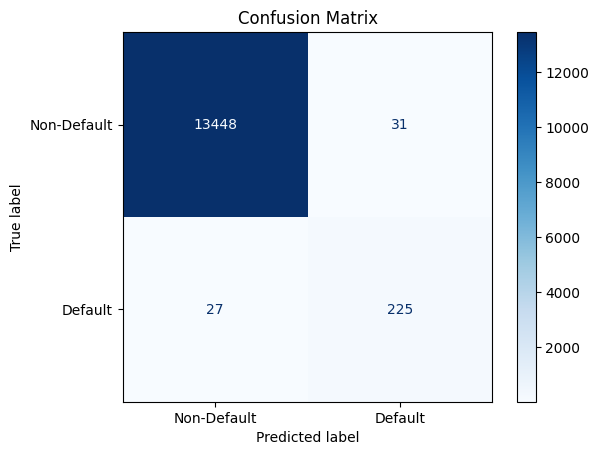

In [341]:
labels = ['No Default', 'Default']
# smote_prediction = best_est.predict(X_test)
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=["Non-Default", "Default"],
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

In [342]:
test_pred = best_model.predict(test_X)
sub = pd.DataFrame(columns=['ID','target'])

sub['ID'] = test_df['id']
sub['target'] = test_pred
sub.to_csv('sub7_lgb_best_cv.csv',index=False)

[LightGBM] [Warning] Unknown parameter: gamma


In [343]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

model = RandomForestClassifier()
scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1')

print(f"Cross-validated F1 Scores: {scores}")
print(f"Mean F1 Score: {scores.mean()}")

[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

F1 Score: 0.8444
ROC AUC Score: 0.9944

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13479
         1.0       0.96      0.75      0.84       252

    accuracy                           0.99     13731
   macro avg       0.98      0.88      0.92     13731
weighted avg       0.99      0.99      0.99     13731



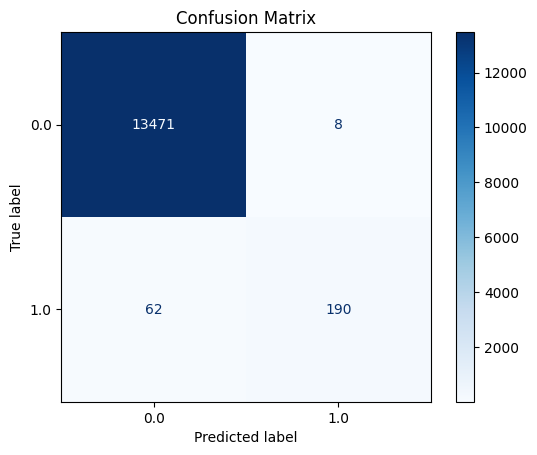

In [344]:
model.fit(X_train,y_train)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=model.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

In [346]:
import xgboost as xgb

def f1_eval(preds, dtrain):
    labels = dtrain.get_label()
    preds_binary = np.round(preds)  # Convert probabilities to binary (0 or 1)
    f1 = f1_score(labels, preds_binary)
    return 'f1', f1

data_dmatrix = xgb.DMatrix(data=X_train,label=y_train)

# params = {"objective":"binary:logistic",'colsample_bytree': 0.5,'learning_rate': 0.1,
#                 'max_depth': 10, 'alpha': 10}

params = {"objective":"binary:logistic",
          'subsample': 0.5, 
          'scale_pos_weight': 53.59542743538768, 
          'reg_lambda': 5, 
          'reg_alpha': 0, 
          'n_estimators': 500, 
          'min_child_weight': 1, 
          'max_depth': 10, 
          'max_delta_step': 3, 
          'learning_rate': 0.3, 
          'gamma': 0.5, 
          'colsample_bytree': 0.5}

xgb_cv = cv(dtrain=data_dmatrix, params=params, nfold=10,
                    num_boost_round=500, early_stopping_rounds=10, 
                    custom_metric=f1_eval, maximize=True, as_pandas=True, seed=42)

In [264]:
xgb_cv

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std,train-f1-mean,train-f1-std,test-f1-mean,test-f1-std
0,0.489557,0.004206,0.491356,0.005352,0.309756,0.016468,0.261395,0.032187
1,0.375639,0.003784,0.379018,0.005853,0.331167,0.004505,0.287873,0.026456
2,0.297124,0.002670,0.300804,0.004686,0.372829,0.009425,0.320978,0.022783
3,0.215424,0.001633,0.219271,0.003441,0.519316,0.008976,0.462010,0.036589
4,0.160022,0.001322,0.163736,0.003151,0.613371,0.010243,0.570187,0.035959
...,...,...,...,...,...,...,...,...
85,0.005089,0.000265,0.017421,0.002289,0.955777,0.003477,0.853610,0.024400
86,0.005075,0.000253,0.017406,0.002290,0.955677,0.003358,0.851664,0.023665
87,0.005024,0.000236,0.017408,0.002354,0.956439,0.003404,0.851375,0.022545
88,0.004905,0.000266,0.017259,0.002299,0.957560,0.003872,0.854829,0.022397


F1 Score: 0.8844
ROC AUC Score: 0.9976

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13479
         1.0       0.90      0.87      0.88       252

    accuracy                           1.00     13731
   macro avg       0.95      0.93      0.94     13731
weighted avg       1.00      1.00      1.00     13731



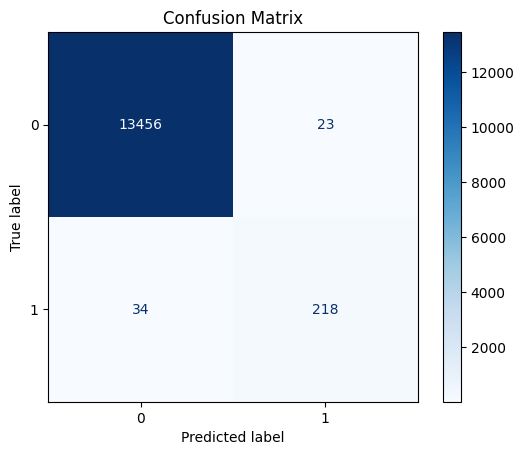

In [265]:
xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model = xgb_clf.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=model.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()

F1 Score: 0.4477
ROC AUC Score: 0.9913

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     13479
         1.0       0.29      0.97      0.45       252

    accuracy                           0.96     13731
   macro avg       0.65      0.96      0.71     13731
weighted avg       0.99      0.96      0.97     13731



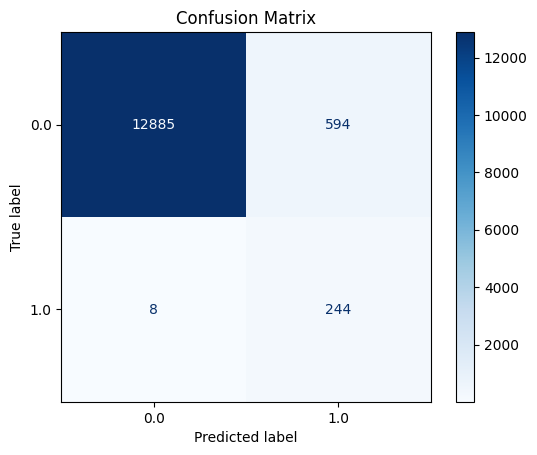

In [266]:
# Logistic Regression Classifier
clf = LogisticRegression(
    random_state=42,
    class_weight="balanced",  # Handle class imbalance
)
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

# Evaluation Metrics
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
# Confusion Matrix Visualization
ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred,
    display_labels=clf.classes_,
    cmap=plt.cm.Blues
)
plt.title("Confusion Matrix")
plt.show()